In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import math
from datetime import datetime
import os
from scipy.stats import norm
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from WindPy import w

pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# get tf_table, t_table

In [2]:
# 设置需要计算的起始日，以及期货的类别
begindate='2018-12-20'
enddate='2020-04-30'
# TF为五年期 T为十年期
fut='TF'
datelist=w.tdays(begindate, enddate, "").Data[0]

##导入债券、期货的行情以及基础数据，并且合并到quota里
bond_quote=pd.read_hdf(fut+'_bond.h5').reset_index(drop=True)
future_quote=pd.read_hdf(fut+'_fut.h5').reset_index(drop=True)
code_info=pd.read_hdf(fut+'_code_info.h5')
quota=pd.DataFrame()
for date in datelist:
    code_code=code_info.loc[((code_info.contract_issue_date<=date) & (code_info.last_trade_date>=date) & (code_info.CARRYDATE<=date))]
    code_code['date']=date
    quota=pd.concat([quota,code_code])
# 合并国债期货、债券详细信息
quota=pd.merge(quota,future_quote,how='left',on=['date','wind_code'])
quota=pd.merge(quota,bond_quote,how='left',on=['date','bond_code'])
# 由于国债在银行间、沪深交易所交易，我们只选用银行间的即可
quota=quota.loc[quota.bond_code.str.contains('.IB')].reset_index(drop=True)
# 期货剩余到期时间
quota['T_t']=(quota.last_delivery_month-quota.date).apply(lambda x:x.days/365.0)
# 计算期货应计利息
# 计算期货到期时，债券的累计利息，fut_AI_T和fut_AI是期货到期日时的应计利息时长和利息
# 方法是用期货到期日-债券发行日除以付息频率的倒数，比如付息频率1，从发行日到期货到期日期限为1.2，
# 那么我们认为到期应计利息时长为0.2，据此计算应计利息
quota['fut_AI_T']=(quota.last_delivery_month-quota.CARRYDATE).apply(lambda x:x.days/365.0)%(1.0/quota.INTERESTFREQUENCY)
quota['fut_AI']=quota['fut_AI_T']*quota['COUPONRATE']
# 计算bond_coupon_paid
quota['coupon_paid1']=((quota.last_delivery_month-quota.CARRYDATE).apply(lambda x:x.days/365.0)/(1.0/quota.INTERESTFREQUENCY)).apply(lambda x:int(x))
quota['coupon_paid2']=((quota.date-quota.CARRYDATE).apply(lambda x:x.days/365.0)/(1.0/quota.INTERESTFREQUENCY)).apply(lambda x:int(x))
quota['bond_coupon_paid']=(quota['coupon_paid1']-quota['coupon_paid2'])*quota['COUPONRATE']/quota.INTERESTFREQUENCY
# IRR期间内付息
quota['Basis']=quota.net_cnbd-quota.settle*quota.CF
quota['IRR']=(quota.settle*quota.CF+quota.fut_AI-quota.dirty_cnbd+quota.bond_coupon_paid)/(quota.dirty_cnbd-quota.bond_coupon_paid)/quota.T_t

# 计算对应T-t的无风险利率，shibor插值
yield_curve=pd.read_hdf('yield_curve.h5')

date_term=quota[['date','wind_code','T_t']].drop_duplicates().reset_index(drop=True)

rf=[]
for i in range(0,date_term.shape[0]):
    date=date_term.date[i]
    term=date_term.T_t[i]
    lower_term=yield_curve.loc[((yield_curve.date==date) & (yield_curve.term<=term)),'term'].max()
    lower_rate=yield_curve.loc[((yield_curve.date==date) & (yield_curve.term==lower_term)),'rate'].values[0]
    upper_term=yield_curve.loc[((yield_curve.date==date) & (yield_curve.term>=term)),'term'].min()
    upper_rate=yield_curve.loc[((yield_curve.date==date) & (yield_curve.term==upper_term)),'rate'].values[0]
    if (upper_term==lower_term):
        rf.append(lower_rate)
    else:
        rf.append((lower_rate*(upper_term-term)+upper_rate*(term-lower_term))/(upper_term-lower_term))
        
date_term['rf']=rf

quota=pd.merge(quota,date_term,how='left',on=['wind_code','date','T_t'])
quota=quota.reset_index(drop=True)
quota['carry']=quota.COUPONRATE*quota.T_t-quota.dirty_cnbd*quota.rf/100*quota.T_t
quota['BNOC']=quota.Basis-quota.carry
# 筛选ctd券，最大IRR
ctd_table=quota.groupby(['date','wind_code']).agg({'IRR':'max'}).reset_index()
ctd_table=pd.merge(ctd_table,quota,how='left',on=['date','wind_code','IRR'])
# 计算ctd券的理论期货价格，这里走个江湖，本应该将债券在期限内的派息折现，但是因为利息的折现值影响不大，所以这里就不折现了
# 隐含标准券期货净价
ctd_table['F_theory']=((ctd_table.dirty_cnbd-ctd_table.bond_coupon_paid)*(1+ctd_table.rf/100.0*ctd_table.T_t)-ctd_table.fut_AI)/ctd_table.CF
ctd_table.to_hdf(fut+'_ctd_table.h5',key='ctd',format='table',mode='w')
# quota.to_hdf(fut+'_quota.h5',key='ctd',format='table',mode='w')


C:\Users\dyang\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 跨期交易策略

## import

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from WindPy import w

pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

w.start()

tf_ctd = pd.read_hdf('TF_ctd_table.h5')
t_ctd = pd.read_hdf('T_ctd_table.h5')

## etc

In [31]:
# 五年期十年期CTD券对比
pd.merge(tf_ctd,t_ctd,on=['date','last_delivery_month'],how='left')[['date','wind_code_x','bond_code_x','wind_code_y','bond_code_y']]

,date,wind_code_x,bond_code_x,wind_code_y,bond_code_y
0,2018-12-20,TF1903.CFE,160014.IB,T1903.CFE,160023.IB
1,2018-12-20,TF1906.CFE,170006.IB,T1906.CFE,160023.IB
2,2018-12-20,TF1909.CFE,170013.IB,T1909.CFE,160023.IB
3,2018-12-21,TF1903.CFE,160014.IB,T1903.CFE,160023.IB
4,2018-12-21,TF1906.CFE,170006.IB,T1906.CFE,160023.IB
...,...,...,...,...,...
985,2020-04-29,TF2009.CFE,190013.IB,T2009.CFE,180011.IB
986,2020-04-29,TF2012.CFE,180020.IB,T2012.CFE,180011.IB
987,2020-04-30,TF2006.CFE,190013.IB,T2006.CFE,180011.IB
988,2020-04-30,TF2009.CFE,190013.IB,T2009.CFE,180011.IB


## Bond price term sturcture

In [64]:
# tf term structure
tf_term = pd.DataFrame({'date':tf_ctd['date'].unique()}).sort_values('date')
tf_term = tf_term.merge(tf_ctd[['date','wind_code','settle','bond_code','net_cnbd','last_delivery_month','T_t']],on='date',how='left')
tf_term['T_t'] = tf_term['T_t']*365
tf_temp = tf_ctd.loc[tf_ctd.groupby(['date'])['T_t'].idxmin()][['date','wind_code','bond_code','net_cnbd','CF']]
tf_temp['T_t'] = 1
tf_temp['settle'] = tf_temp['net_cnbd']/tf_temp['CF']
tf_term = pd.concat([tf_term,tf_temp])
tf_term = tf_term.sort_values(['date','T_t'])[['date','wind_code','bond_code','T_t','settle']].reset_index(drop=True)

In [66]:
# t term structure
t_term = pd.DataFrame({'date':t_ctd['date'].unique()}).sort_values('date')
t_term = t_term.merge(t_ctd[['date','wind_code','settle','bond_code','net_cnbd','last_delivery_month','T_t']],on='date',how='left')
t_term['T_t'] = t_term['T_t']*365
t_temp = t_ctd.loc[t_ctd.groupby(['date'])['T_t'].idxmin()][['date','wind_code','bond_code','net_cnbd','CF']]
t_temp['T_t'] = 1
t_temp['settle'] = t_temp['net_cnbd']/t_temp['CF']
t_term = pd.concat([t_term,t_temp])
t_term = t_term.sort_values(['date','T_t'])[['date','wind_code','bond_code','T_t','settle']].reset_index(drop=True)

In [106]:
# term structure graph
ts_graph = pd.merge(tf_term[['date','T_t','settle']],t_term[['date','T_t','settle']],on=['date','T_t'],how='left')
ts_graph.columns = ['date','T_t','tf_settle','t_settle']

### term structure graph

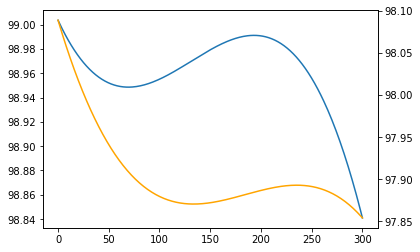

In [677]:
# spline method
from scipy.interpolate import make_interp_spline, BSpline
to_graph = ts_graph[ts_graph['date'] == '2019-01-07']
fig,ax1 = plt.subplots()
x_new = np.linspace(0,300,300)
spl_tf = make_interp_spline(to_graph['T_t'],to_graph['tf_settle'], k=3)
smooth_tf=spl_tf(x_new)
ax1.plot(x_new,smooth_y)
ax2 = ax1.twinx() 
# x_new = np.linspace(0,300,300)
spl_t = make_interp_spline(to_graph['T_t'],to_graph['t_settle'], k=3)
smooth_t=spl_t(x_new)
ax2.plot(x_new,smooth_t,color='orange')
plt.show()

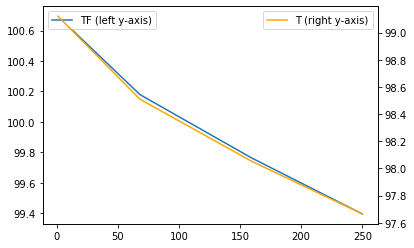

In [681]:
ts_temp = ts_graph[ts_graph['date'] == '2020-01-10']
fig,ax1 = plt.subplots()
min_ylim = min(min(ts_temp['tf_settle']),min(ts_temp['t_settle']))-0.3
max_ylim = max(max(ts_temp['tf_settle']),max(ts_temp['t_settle']))+0.3
# ax1.set_ylim(min_ylim,max_ylim)
# ax2.set_ylim(min_ylim,max_ylim)
ax1.plot(ts_temp['T_t'],ts_temp['tf_settle'],label='TF (left y-axis)')
ax2 = ax1.twinx() 
ax2.plot(ts_temp['T_t'],ts_temp['t_settle'],color='orange',label='T (right y-axis)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

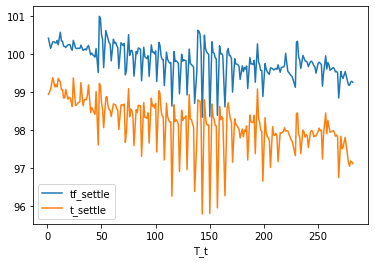

In [660]:
# mean
ts_graph.groupby('T_t').mean().plot()

## BNOC term structure

In [186]:
tf_bnoc = tf_ctd[['date','T_t','BNOC']].copy()
tf_bnoc['T_t'] = tf_bnoc['T_t']*365
t_bnoc = t_ctd[['date','T_t','BNOC']].copy()
t_bnoc['T_t'] = t_bnoc['T_t']*365
bnoc_graph = tf_bnoc.merge(t_bnoc,on=['date','T_t'],how='left')
bnoc_graph.columns = ['date','T_t','tf_bnoc','t_bnoc']

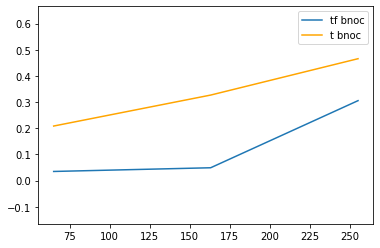

In [703]:
bnoc_temp = bnoc_graph[bnoc_graph['date'] == '2019-01-07']
fig,ax = plt.subplots()
min_ylim = min(min(bnoc_temp['tf_bnoc']),min(bnoc_temp['t_bnoc']))-0.2
max_ylim = max(max(bnoc_temp['tf_bnoc']),max(bnoc_temp['t_bnoc']))+0.2
ax.set_ylim(min_ylim,max_ylim)
ax.plot(bnoc_temp['T_t'],bnoc_temp['tf_bnoc'],label='tf bnoc')
ax.plot(bnoc_temp['T_t'],bnoc_temp['t_bnoc'],color='orange',label='t bnoc')
ax.legend()

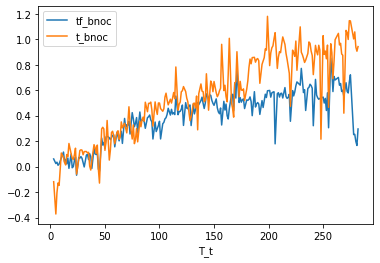

In [694]:
bnoc_graph.groupby('T_t').mean().plot()

## actual spread

In [251]:
actual_spread= ts_graph.copy()
actual_spread['tf_diff'] = -actual_spread.groupby('date')['tf_settle'].diff().shift(-1)
actual_spread['t_diff'] = -actual_spread.groupby('date')['t_settle'].diff().shift(-1)
actual_spread = actual_spread.dropna()

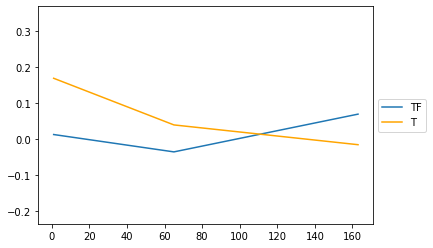

In [714]:
as_temp = actual_spread[(actual_spread['date'] == '2019-01-07')]
fig,ax = plt.subplots()
min_ylim = min(min(as_temp['tf_diff']),min(as_temp['t_diff']))-0.2
max_ylim = max(max(as_temp['tf_diff']),max(as_temp['t_diff']))+0.2
ax.set_ylim(min_ylim,max_ylim)
ax.plot(as_temp['T_t'],as_temp['tf_diff'],label='TF')
ax.plot(as_temp['T_t'],as_temp['t_diff'],color='orange',label='T')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

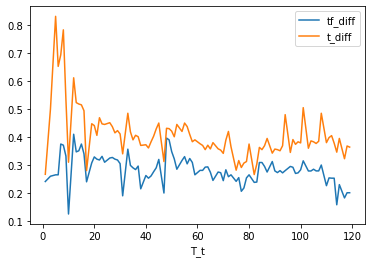

In [719]:
actual_spread[actual_spread['T_t']<120][['T_t','tf_diff','t_diff']].groupby('T_t').mean().plot()

## 历史数据

In [910]:
%%time

# !!!  CHANGE HERE  !!!
# using tf_ctd or t_ctd
df = tf_ctd.copy()
fut_list = df['wind_code'].unique()

# 跨期价差计算
diff = pd.DataFrame(columns=['contract','near','next','date','last','diff'])
for i,k in enumerate(fut_list[1:]):
    near_month = fut_list[i]
    next_month = k
    s = near_month + '-' + next_month
    date_set_near = set(df[df['wind_code'] == near_month]['date'])
    date_set_next = set(df[df['wind_code'] == next_month]['date'])
    # 两个合约都有交易都有交易
    date_set = date_set_near.intersection(date_set_next)
    for date in date_set:
        p_near = df.loc[(df['wind_code']== near_month)&(df['date'] == date),'settle'].values[0]
        p_next = df.loc[(df['wind_code']== next_month)&(df['date'] == date),'settle'].values[0]
        # 期货价格 = 理论价格 - 期权BNOC
        # 希望远端BNOC上涨（期货价格下跌），近端BNOC下跌（期货价格上涨）
        # 买近卖远
        p_diff =  p_near - p_next
        # 计算到近月到期
        last = df[(df['date']==date)&(df['wind_code']==near_month)]['last_delivery_month'].values[0]
        to_append = {'contract':s,'near':near_month,'next':next_month,'date':date,'last':last,'diff':p_near-p_next}
        diff = diff.append(to_append,ignore_index=True)

diff['days'] = (diff['last'] - diff['date']).dt.days
diff = diff.sort_values(['contract','date']).reset_index(drop=True)

Wall time: 2.21 s


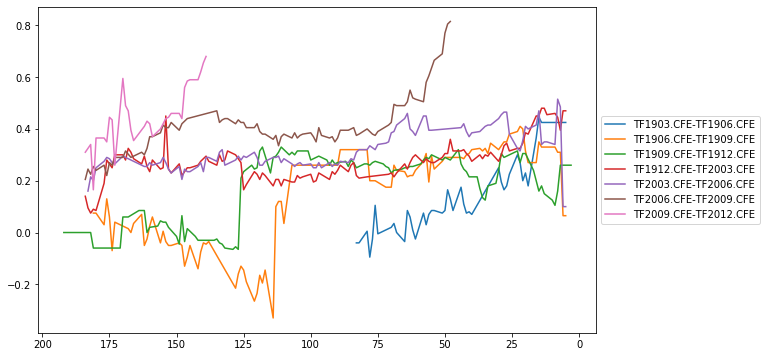

In [908]:
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.invert_xaxis()
for contract in diff['contract'].unique():
    diff_clip = diff[diff['contract']==contract]
    ax.plot(diff_clip['days'],diff_clip['diff'],label=contract)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

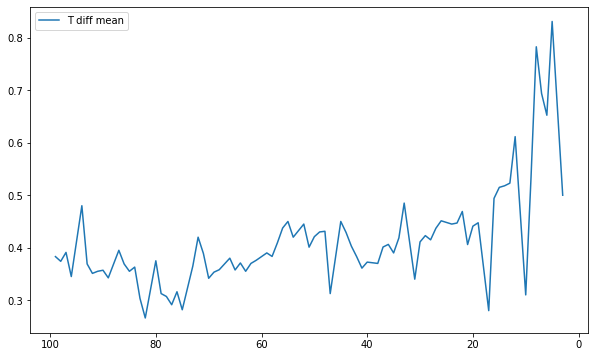

In [904]:
# diff_select = diff[~diff['contract'].str.contains('TF2003.CFE-TF2006.CFE')].copy()
diff_select = diff.copy()
# 组合波动率加剧
fig, ax = plt.subplots(figsize=(10, 6))
ax.invert_xaxis()
ax.plot(diff_select[diff_select['days']<100].groupby('days').mean(),label='T diff mean')
ax.legend()

## 交易策略

In [739]:
diff.contract.unique()

array(['TF1903.CFE-TF1906.CFE', 'TF1906.CFE-TF1909.CFE',
       'TF1909.CFE-TF1912.CFE', 'TF1912.CFE-TF2003.CFE',
       'TF2003.CFE-TF2006.CFE', 'TF2006.CFE-TF2009.CFE',
       'TF2009.CFE-TF2012.CFE'], dtype=object)

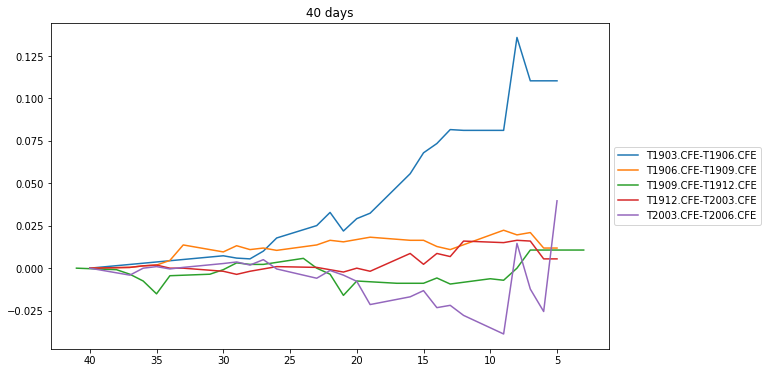

In [905]:
# 收益计算
# single plot


day_test = 40
# !!!  CHANGE ABOVE  !!!
# cont_list = [
#             'TF1903.CFE-TF1906.CFE', 
#             'TF1906.CFE-TF1909.CFE',
#             'TF1909.CFE-TF1912.CFE',
#             'TF1912.CFE-TF2003.CFE',
#             'TF2003.CFE-TF2006.CFE',
#             ]

cont_list = [
            'T1903.CFE-T1906.CFE', 
            'T1906.CFE-T1909.CFE',
            'T1909.CFE-T1912.CFE',
            'T1912.CFE-T2003.CFE',
            'T2003.CFE-T2006.CFE',
            ]

fig, ax = plt.subplots(figsize=(10, 6))
ax.invert_xaxis()

# create 
df_profit = pd.DataFrame()
for contract in cont_list:
    df_pf = diff[diff['contract']==contract].copy()
    day_bound = df_pf.iloc[(df_pf['days']-day_test).abs().argsort()[:1]]['days'].values[0]
    df_pf = df_pf[df_pf['days']<=day_bound].sort_values(['contract','date']).reset_index(drop=True)
    cost = df_pf[df_pf['days']==day_bound]['diff'].values[0]
    # 按100%保证金计算，除100，回头再加杠杆
    df_pf['profit_pct'] = (df_pf['diff'] - cost)/100 * 365/day_bound
    df_profit = pd.concat([df_profit,df_pf])
    ax.plot(df_pf['days'],df_pf['profit_pct'],label=contract)

ax.set_title('{} days'.format(day_test))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

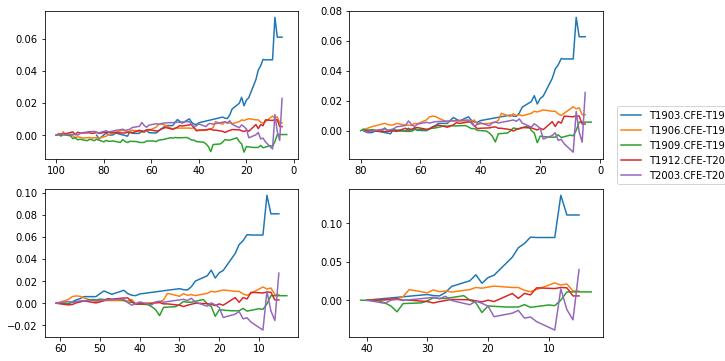

In [911]:
# 收益计算
# 组合图


# !!!  CHANGE ABOVE  !!!
# cont_list = [
#             'TF1903.CFE-TF1906.CFE', 
#             'TF1906.CFE-TF1909.CFE',
#             'TF1909.CFE-TF1912.CFE',
#             'TF1912.CFE-TF2003.CFE',
#             'TF2003.CFE-TF2006.CFE',
#             ]

cont_list = [
            'T1903.CFE-T1906.CFE', 
            'T1906.CFE-T1909.CFE',
            'T1909.CFE-T1912.CFE',
            'T1912.CFE-T2003.CFE',
            'T2003.CFE-T2006.CFE',
            ]

fig, axs = plt.subplots(2,2,figsize=(10, 6))

days_list = [100,80,60,40]
for i in range(1,5):
    plt.subplot(2, 2, i)
#     df_profit = pd.DataFrame()
    for contract in cont_list:
        df_pf = diff[diff['contract']==contract].copy()
        day_bound = df_pf.iloc[(df_pf['days']-days_list[i-1]).abs().argsort()[:1]]['days'].values[0]
        df_pf = df_pf[df_pf['days']<=day_bound].sort_values(['contract','date']).reset_index(drop=True)
        cost = df_pf[df_pf['days']==day_bound]['diff'].values[0]
        # 按100%保证金计算，除100，回头再加杠杆
        df_pf['profit_pct'] = (df_pf['diff'] - cost)/100 * 365/day_bound
#         df_profit = pd.concat([df_profit,df_pf])
        plt.gca().invert_xaxis()
        plt.plot(df_pf['days'],df_pf['profit_pct'],label=contract)


handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels,loc='center left',bbox_to_anchor=(0.85,0.5))